In [2]:
# reference: https://towardsdatascience.com/pos-tagging-using-rnn-7f08a522f849

In [3]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, TimeDistributed, Dense
from keras.utils import to_categorical
import gensim.models as gm
import nltk
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from sklearn.model_selection import GridSearchCV
import keras
from scikeras.wrappers import KerasClassifier


2023-03-09 16:30:12.810642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 16:30:13.202811: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-09 16:30:13.202873: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-09 16:30:14.591187: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
import conllu

# Read the CoNLL-U file
data_file = open("./UD_English-Atis/en_atis-ud-train.conllu", "r", encoding="utf-8")
data = conllu.parse(data_file.read())

val_file = open("./UD_English-Atis/en_atis-ud-dev.conllu", "r", encoding="utf-8")
val = conllu.parse(val_file.read())

test_file = open("./UD_English-Atis/en_atis-ud-test.conllu", "r", encoding="utf-8")
test = conllu.parse(test_file.read())

# Extract the features and labels
X_train = []
y_train = []
tags = set([])
for sentence in data:
    sentence_words = []
    sentence_labels = []
    for token in sentence:
        tags.add(token["upos"])
        sentence_words.append(token["form"])
        sentence_labels.append(token["upos"])
    X_train.append(sentence_words)
    y_train.append(sentence_labels)

X_val = []
y_val = []
for sentence in val:
    sentence_words = []
    sentence_labels = []
    for token in sentence:
        sentence_words.append(token["form"])
        sentence_labels.append(token["upos"])
    X_val.append(sentence_words)
    y_val.append(sentence_labels)

X_test = []
y_test = []
for sentence in test:
    sentence_words = []
    sentence_labels = []
    for token in sentence:
        sentence_words.append(token["form"])
        sentence_labels.append(token["upos"])
    X_test.append(sentence_words)
    y_test.append(sentence_labels)


In [5]:
all_words = []
for words in X_train:
    all_words.extend(words)
freq_dist = nltk.FreqDist(all_words)
vocab = {word: count for word, count in freq_dist.items()}

for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        if X_train[i][j] in vocab and vocab[X_train[i][j]]<2:
            X_train[i][j] = 'ukn'

for i in range(len(X_val)):
    for j in range(len(X_val[i])):
        if X_val[i][j] in vocab and vocab[X_val[i][j]]<2:
            X_val[i][j] = 'ukn'

for i in range(len(X_test)):
    for j in range(len(X_test[i])):
        if X_test[i][j] in vocab and vocab[X_test[i][j]]<2:
            X_test[i][j] = 'ukn'


In [6]:
print(tags, len(tags))

{'CCONJ', 'PART', 'AUX', 'DET', 'ADJ', 'VERB', 'PRON', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'NUM', 'ADP'} 13


In [7]:
word_tokenizer = Tokenizer()              
word_tokenizer.fit_on_texts(X_train)       

X_train_encoded = word_tokenizer.texts_to_sequences(X_train)  
X_val_encoded = word_tokenizer.texts_to_sequences(X_val)
X_test_encoded = word_tokenizer.texts_to_sequences(X_test)

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y_train)

y_train_encoded = tag_tokenizer.texts_to_sequences(y_train)
y_val_encoded = tag_tokenizer.texts_to_sequences(y_val)
y_test_encoded = tag_tokenizer.texts_to_sequences(y_test)


In [8]:
tag_tokenizer.word_index

{'propn': 1,
 'adp': 2,
 'noun': 3,
 'verb': 4,
 'det': 5,
 'pron': 6,
 'aux': 7,
 'adj': 8,
 'num': 9,
 'cconj': 10,
 'adv': 11,
 'part': 12,
 'intj': 13}

In [9]:
word_tokenizer.word_index

{'to': 1,
 'from': 2,
 'flights': 3,
 'the': 4,
 'on': 5,
 'what': 6,
 'flight': 7,
 'me': 8,
 'i': 9,
 'show': 10,
 'san': 11,
 'boston': 12,
 'a': 13,
 'denver': 14,
 'in': 15,
 'francisco': 16,
 'and': 17,
 'atlanta': 18,
 'is': 19,
 'dallas': 20,
 'pittsburgh': 21,
 'all': 22,
 'list': 23,
 'baltimore': 24,
 'philadelphia': 25,
 'like': 26,
 'are': 27,
 'airlines': 28,
 'that': 29,
 'washington': 30,
 'of': 31,
 'between': 32,
 'please': 33,
 'morning': 34,
 'ukn': 35,
 'leaving': 36,
 'pm': 37,
 'would': 38,
 'fly': 39,
 'city': 40,
 'for': 41,
 'need': 42,
 'fare': 43,
 'wednesday': 44,
 'first': 45,
 'after': 46,
 'there': 47,
 'oakland': 48,
 'trip': 49,
 'ground': 50,
 'arriving': 51,
 'you': 52,
 'cheapest': 53,
 'which': 54,
 'round': 55,
 'transportation': 56,
 "'d": 57,
 'before': 58,
 'does': 59,
 'class': 60,
 'with': 61,
 'available': 62,
 'st.': 63,
 'one': 64,
 'afternoon': 65,
 'milwaukee': 66,
 'new': 67,
 'have': 68,
 'at': 69,
 'way': 70,
 'american': 71,
 'fares'

In [10]:
print(word_tokenizer.word_index, '\n')
print(word_tokenizer.word_index.items(), '\n')
print(len(word_tokenizer.word_index), '\n')

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'flight': 7, 'me': 8, 'i': 9, 'show': 10, 'san': 11, 'boston': 12, 'a': 13, 'denver': 14, 'in': 15, 'francisco': 16, 'and': 17, 'atlanta': 18, 'is': 19, 'dallas': 20, 'pittsburgh': 21, 'all': 22, 'list': 23, 'baltimore': 24, 'philadelphia': 25, 'like': 26, 'are': 27, 'airlines': 28, 'that': 29, 'washington': 30, 'of': 31, 'between': 32, 'please': 33, 'morning': 34, 'ukn': 35, 'leaving': 36, 'pm': 37, 'would': 38, 'fly': 39, 'city': 40, 'for': 41, 'need': 42, 'fare': 43, 'wednesday': 44, 'first': 45, 'after': 46, 'there': 47, 'oakland': 48, 'trip': 49, 'ground': 50, 'arriving': 51, 'you': 52, 'cheapest': 53, 'which': 54, 'round': 55, 'transportation': 56, "'d": 57, 'before': 58, 'does': 59, 'class': 60, 'with': 61, 'available': 62, 'st.': 63, 'one': 64, 'afternoon': 65, 'milwaukee': 66, 'new': 67, 'have': 68, 'at': 69, 'way': 70, 'american': 71, 'fares': 72, 'dc': 73, 'york': 74, 'give': 75, 'leave': 76, 'thursday': 77, 'a

In [11]:
l=0
m = 100
for x in X_train:
    l = max(l, len(x))
    m = min(m, len(x))
print(l, m)

46 2


In [12]:
print(X_train)

[['what', 'is', 'the', 'cost', 'of', 'a', 'round', 'trip', 'flight', 'from', 'pittsburgh', 'to', 'atlanta', 'ukn', 'on', 'april', 'twenty', 'fifth', 'and', 'returning', 'on', 'may', 'sixth'], ['now', 'i', 'need', 'a', 'flight', 'leaving', 'fort', 'worth', 'and', 'arriving', 'in', 'denver', 'no', 'later', 'than', '2', 'pm', 'next', 'monday'], ['i', 'need', 'to', 'fly', 'from', 'kansas', 'city', 'to', 'chicago', 'leaving', 'next', 'wednesday', 'and', 'returning', 'the', 'following', 'day'], ['what', 'is', 'the', 'meaning', 'of', 'meal', 'code', 's'], ['show', 'me', 'all', 'flights', 'from', 'denver', 'to', 'pittsburgh', 'which', 'serve', 'a', 'meal', 'for', 'the', 'day', 'after', 'tomorrow'], ['show', 'me', 'all', 'us', 'air', 'flights', 'from', 'atlanta', 'to', 'denver', 'for', 'the', 'day', 'after', 'tomorrow'], ['list', 'the', 'nonstop', 'flights', 'early', 'tuesday', 'morning', 'from', 'dallas', 'to', 'atlanta'], ['show', 'me', 'the', 'flights', 'from', 'st.', 'petersburg', 'to', 'to

In [13]:
MAX_SEQ_LENGTH = 46
padded_X_train = pad_sequences(X_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
padded_y_train = pad_sequences(y_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
print(padded_X_train[0])
print(padded_y_train[0])
print()
padded_X_val = pad_sequences(X_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
padded_y_val = pad_sequences(y_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
print(padded_X_val[0])
print(padded_y_val[0])
print()
padded_X_test = pad_sequences(X_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
padded_y_test = pad_sequences(y_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
print(padded_X_test[0])
print(padded_y_test[0])


[  6  19   4 159  31  13  55  49   7   2  21   1  18  35   5 183  99 232
  17 350   5 168 252   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[ 6  7  5  3  2  5  3  3  3  2  1  2  1  4  2  3  9  8 10  4  2  3  8  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

[  9  38  26   4  53   7   2  21   1  18  36 183  99 232  17 350 168 252
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[ 6  7  4  5  8  3  2  1  2  1  4  3  9  8 10  4  3  8  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

[  6  27   4 189   3  32  20  17  24  36 120 271  17 350 120   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[ 6  7  5  3  3  2  1 10  1  4  3  8 10  4  3  9  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [41]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=len(word_tokenizer.word_index) + 1, output_dim=64, input_length=MAX_SEQ_LENGTH))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
# model.add(Dense(units=32))
model.add(Dense(units=len(tag_tokenizer.word_index) + 1, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(padded_X_train, padded_y_train, validation_data=(padded_X_val, padded_y_val), epochs=10, batch_size=32)

Epoch 1/10
134/134 [==============================] - 11s 52ms/step - loss: 0.8048 - accuracy: 0.7812 - val_loss: 0.5086 - val_accuracy: 0.8288
Epoch 2/10
134/134 [==============================] - 5s 34ms/step - loss: 0.3906 - accuracy: 0.8878 - val_loss: 0.2855 - val_accuracy: 0.9270
Epoch 3/10
134/134 [==============================] - 5s 35ms/step - loss: 0.1708 - accuracy: 0.9571 - val_loss: 0.1430 - val_accuracy: 0.9731
Epoch 4/10
134/134 [==============================] - 4s 33ms/step - loss: 0.0734 - accuracy: 0.9858 - val_loss: 0.0943 - val_accuracy: 0.9834
Epoch 5/10
134/134 [==============================] - 4s 29ms/step - loss: 0.0382 - accuracy: 0.9915 - val_loss: 0.0815 - val_accuracy: 0.9872
Epoch 6/10
134/134 [==============================] - 4s 27ms/step - loss: 0.0250 - accuracy: 0.9944 - val_loss: 0.0790 - val_accuracy: 0.9875
Epoch 7/10
134/134 [==============================] - 5s 34ms/step - loss: 0.0193 - accuracy: 0.9951 - val_loss: 0.0793 - val_accuracy: 0.988

In [42]:
loss, accuracy = model.evaluate(padded_X_test, padded_y_test, verbose = 1)

19/19 [==============================] - 0s 13ms/step - loss: 0.0756 - accuracy: 0.9903


In [40]:
model.save("my_model2.h5")

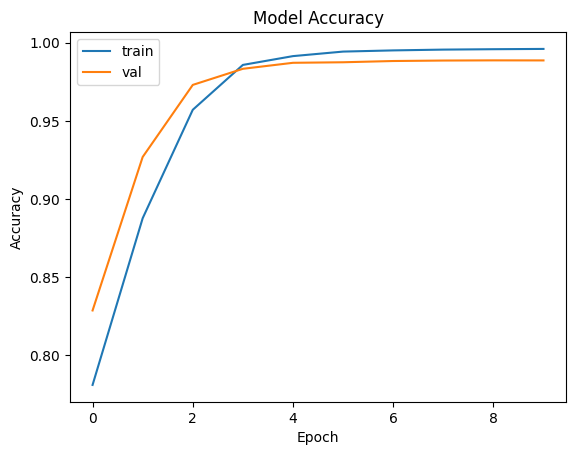

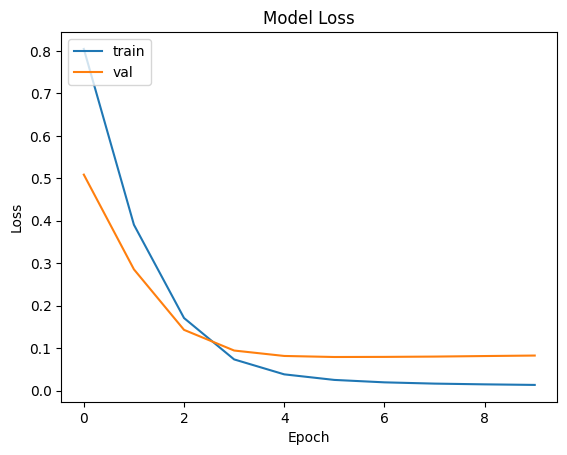

In [43]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [45]:
# sentence = "what is the cost of a round trip flight from pittsburgh to atlanta beginning on"
#pron, verb, det, noun, adp, propn, adp, propn, adp, propn, adp, verb, det, adj, adp, num, noun
# sentence = "i want a flight from nashville to seattle that arrives no later than 3 pm"
sentence="Mary had a little lamb"

def printPreds(sentence):
    tokens = nltk.word_tokenize(sentence)
    tokens_st = tokens[:]
    new_sentence = ""
    for j in range(len(tokens)):
            if tokens[j] not in vocab or vocab[tokens[j]]<2:
                tokens[j] = 'ukn'
            new_sentence+=tokens[j]
            if j!=len(tokens)-1:
                new_sentence+=" "
        

    sentence_tokens = word_tokenizer.texts_to_sequences([new_sentence])

    padded_sentence = pad_sequences(sentence_tokens, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
    predicted_tags_encoded = model.predict(padded_sentence)
    length = len(sentence_tokens[0])
    predicted_tags = []
    for i in range(length):
        idx = np.argmax(predicted_tags_encoded[0][i])
        for (word, i) in tag_tokenizer.word_index.items():
            if idx == i:
                predicted_tags.append(word)
    print(predicted_tags)

    for i in range(len(predicted_tags)):
        print(tokens_st[i], '\t', predicted_tags[i])

printPreds(sentence)


# NOUN, VERB, DET, ADJ, NOUN

1/1 [==============================] - 0s 31ms/step
['verb', 'verb', 'det', 'noun', 'noun']
Mary 	 verb
had 	 verb
a 	 det
little 	 noun
lamb 	 noun


In [93]:
from sklearn.metrics import classification_report

# Predict on validation set
pred = model.predict(padded_X_val)
y_p = []
for i in range(len(y_val_encoded)):
    no_words = len(y_val_encoded[i])
    all_words = pred[i]
    vals = []
    for j in range(no_words):
        vals.append(np.argmax(all_words[j]))
    for j in range(no_words, MAX_SEQ_LENGTH):
        vals.append(0)
    y_p.append(vals)

y_pred = np.array(y_p)
y_true = padded_y_val

18/18 [==============================] - 0s 15ms/step


In [96]:
np.all(y_pred == y_true)

False

In [97]:
report = classification_report(y_true, y_pred)
print(report)

ValueError: multiclass-multioutput is not supported

In [90]:
padded_y_val

array([[6, 7, 4, ..., 0, 0, 0],
       [6, 4, 5, ..., 0, 0, 0],
       [4, 6, 3, ..., 0, 0, 0],
       ...,
       [3, 2, 1, ..., 0, 0, 0],
       [5, 3, 4, ..., 0, 0, 0],
       [7, 5, 5, ..., 0, 0, 0]], dtype=int32)

In [80]:
padded_y_val

array([[6, 7, 4, ..., 0, 0, 0],
       [6, 4, 5, ..., 0, 0, 0],
       [4, 6, 3, ..., 0, 0, 0],
       ...,
       [3, 2, 1, ..., 0, 0, 0],
       [5, 3, 4, ..., 0, 0, 0],
       [7, 5, 5, ..., 0, 0, 0]], dtype=int32)

In [67]:
len(X_train)

4274

In [23]:
tag_tokenizer.word_index

{'propn': 1,
 'adp': 2,
 'noun': 3,
 'verb': 4,
 'det': 5,
 'pron': 6,
 'aux': 7,
 'adj': 8,
 'num': 9,
 'cconj': 10,
 'adv': 11,
 'part': 12,
 'intj': 13}